In [299]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import geopy.distance
import os
import plotly.graph_objects as go
from shapely.geometry import shape, Point
import seaborn as sns
import matplotlib as mpl
import folium
import re
import seaborn as sns
from datetime import datetime
import pytz
from pytz import timezone
#from google.colab import drive
import datetime
from datetime import timedelta
import time
import folium
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.geocoders import ArcGIS
import concurrent.futures
from geopy.distance import geodesic
from uszipcode import SearchEngine
from pandarallel import pandarallel
import pgeocode

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [300]:
df = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Session-Details-Summary-20240605.csv')
df_tn_reg = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\TN_EV_Registrations.csv')
df_venue= pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\lat_long_charging_venue.csv')
df_GIS= pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\rechargingstationproject\GIS_distance.xlsx', sheet_name='Total')
df_tn_population = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\tennessee_counties_population.csv')
df_tn_AADT = pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\TN_AADT_TDOT.xlsx')
df_tn_MHHI_county = pd.read_excel(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\Median_H_H_Income.xlsx')
df_tn_TEMP_county = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\2023_TN_County_Average_Temperature.csv')
df_tn_Cooling_Degree_Days_county = pd.read_csv(r'C:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\DATA\2023_TN_County_Cooling_Degree_Days.csv')


In [301]:
# Filter the DataFrame for the state of Tennessee
tennessee_df = df[df['State/Province'] == 'Tennessee']

# Get the number of unique EVSE IDs in Tennessee
unique_evse_ids_tennessee = tennessee_df['EVSE ID'].nunique()
print(f"Number of unique EVSE IDs in Tennessee: {unique_evse_ids_tennessee}")


num_nan_start_soc = df['End SOC'].isna().sum()
print(f"Number of NaN values in 'Start SOC' column: {num_nan_start_soc}")

num_nan_Driver_Zip_Postal_Code = df['Driver Zip/Postal Code'].isna().sum()
print(f"Number of NaN values in 'Driver zip code' column: {num_nan_Driver_Zip_Postal_Code}")

Number of unique EVSE IDs in Tennessee: 80
Number of NaN values in 'Start SOC' column: 30473
Number of NaN values in 'Driver zip code' column: 8889


In [302]:
df = df[df['Energy (kWh)'] != 0]   # remove rows with no Energy 
df['Driver Zip/Postal Code'] = df['Driver Zip/Postal Code'].fillna(df['Zip/Postal Code'])
missing_count_port_type = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Remove specified columns
columns_to_remove = ['Station Name', 'Address 1', 'City', 'Zip/Postal Code', 'State/Province', 'Latitude', 'Longitude']
df = df.drop(columns=columns_to_remove)

# Merge with venue information
df = pd.merge(df, df_venue[['EVSE ID', 'Charging Venue', 'Station Name', 'Address 1', 'City', 'Zip/Postal Code', 'State/Province', 'Latitude (y)', 'Longitude (x)']], on='EVSE ID', how='left')


In [303]:
#Calculate distance 
dist = pgeocode.GeoDistance('us')         
def calculate_distance_miles(zip1, zip2):
    try:
        distance_km = dist.query_postal_code(zip1, zip2)
        distance_miles = distance_km * 0.621371
        return distance_miles
    except ValueError:
        return None

df['Distance (miles)'] = df.apply(lambda row: calculate_distance_miles(row['Zip/Postal Code'], row['Driver Zip/Postal Code']), axis=1)  

In [304]:
nan_count_driver_zipcode = df['Driver Zip/Postal Code'].isna().sum()
nan_count_distance = df['Distance (miles)'].isna().sum()
nan_count_station_zip = df['Zip/Postal Code'].isna().sum()

print(f"Number of NaN values in 'Driver Zip/Postal Code': {nan_count_driver_zipcode}")
print(f"Number of NaN values in 'Distance': {nan_count_distance}")
print(f"Number of NaN values in 'station zipcode': {nan_count_station_zip}")

Number of NaN values in 'Driver Zip/Postal Code': 0
Number of NaN values in 'Distance': 885
Number of NaN values in 'station zipcode': 0


In [305]:
df = df.dropna(subset=['Distance (miles)'])

In [306]:
def mean_excluding_zeros(series):
    non_zero_values = series[series != 0]
    if len(non_zero_values) > 0:
        return np.mean(non_zero_values)
    else:
        return np.nan
#-----------------------------
def convert_duration_to_seconds(duration):
    if isinstance(duration, str):
        parts = duration.split(':')
        if len(parts) >= 3:
            try:
                hours = int(parts[0])
                minutes = int(parts[1])
                seconds = int(parts[2].split()[0])
                total_seconds = hours * 3600 + minutes * 60 + seconds
                return total_seconds
            except (IndexError, ValueError):
                print("Invalid duration format")
                return 0
        else:
            print("Invalid duration format")
            return 0
    elif isinstance(duration, datetime.time):
        return duration.hour * 3600 + duration.minute * 60 + duration.second
    else:
        return 0
#--------------------------------------------------------------------------------

def convert_to_est_old(row, date_col, tz_col):
    tz_map = {'EST': 'America/New_York', 'CST': 'America/Chicago', 'CDT': 'America/Chicago', 'EDT': 'America/New_York', 'PDT': 'America/Los_Angeles', 'PST': 'America/Los_Angeles'}
    return row[date_col].tz_localize(tz=tz_map[row[tz_col]], ambiguous='NaT').tz_convert(tz='EST')


time_zones = {
    'EST': 'America/New_York',
    'CST': 'America/Chicago',
    'CDT': 'America/Chicago',
    'EDT': 'America/New_York',
    'PDT': 'America/Los_Angeles',
    'PST': 'America/Los_Angeles'
}

# Convert time zones
def convert_to_est(row):
    est_tz = timezone('America/New_York')
    start_tz = timezone(time_zones[row['Start Time Zone']])
    end_tz = timezone(time_zones[row['End Time Zone']])

    row['Start Date'] = row['Start Date'].astimezone(start_tz).astimezone(est_tz)
    row['End Date'] = row['End Date'].astimezone(end_tz).astimezone(est_tz)

    return row

#--------------------------------------------------------------------------------

missing_count = df['Port Type'].value_counts().get('Missing', 0)
df = df.dropna(subset=['Port Type'])

# Apply function to Start and End Date
df['Start_Time_EST'] = pd.to_datetime(df['Start Date'])
df['End_Time_EST'] = pd.to_datetime(df['End Date'])


#sorting
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])


#    Total duration  Charging time   parking time   End charging Time

df['Total Duration'] = (df['Total Duration (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
df['Charging Time'] = (df['Charging Time (hh:mm:ss)'].apply(convert_duration_to_seconds))/3600
#df['Charging Time (dayTime)'] = df['Charging Time (hh:mm:ss)'].apply(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))
df.loc[df['Charging Time'] > df['Total Duration'], 'Charging Time'] = df['Total Duration']
df['parking_time'] = df['Total Duration'] - df['Charging Time']
df['End_Charging_Time_EST'] = [date + timedelta(hours=chargingtime) for date, chargingtime in df[['Start_Time_EST','Charging Time']].itertuples(index=False)]
#df['End_Charging_Time_EST_2']= df['Start_Time_EST'] +df['Charging Time (dayTime)']

# Data cleaning 
# sessions with delivered energy > 140 kWh, since these are incompatible with the usable battery capacities of the Rivian 
# R1T and extended-range Ford F-150 Lighting, the two mass-market EVs with the largest batteries available through March 2022;
# (2) sessions with a charge duration of 0 h or where no energy was delivered; 

df = df[(df['Energy (kWh)'] != 0) & (df['Energy (kWh)'] <= 140) & (df['Charging Time']!=0)]

In [290]:
nan_start_soc = df['Start SOC'].isna().sum()
print(f"Number of NaN values in 'Start SOC': {nan_start_soc}")

nan_end_soc = df['End SOC'].isna().sum()
print(f"Number of NaN values in 'End SOC': {nan_end_soc}")

Number of NaN values in 'Start SOC': 23647
Number of NaN values in 'End SOC': 23416


In [307]:


# wich day of week
df['Day_of_Week'] = df['Start_Time_EST'].dt.dayofweek

# Create new columns 'Is_Weekday' and 'Is_Weekend'
df['Is_Weekday'] = df['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6]).astype(int)

# Peak hour 
# Add a new column 'peak_hour'
df['Start_Time_EST_Day'] = pd.to_datetime(df['Start_Time_EST']).dt.hour
df['peak_hour'] = ((df['Start_Time_EST_Day'] >= 6) & (df['Start_Time_EST_Day'] <= 20)).astype(int)


# Extract the month from 'Start Date'
df['month'] = pd.to_datetime(df['Start_Time_EST']).dt.month

def month_to_season(month):
    if month in [12, 1, 2]:
        return 4  # Winter
    elif month in [3, 4, 5]:
        return 1  # Spring
    elif month in [6, 7, 8]:
        return 2  # Summer
    else:
        return 3  # Fall

df['season'] = df['month'].apply(month_to_season)



# Create new columns 'DC' and 'L2'
df['DC'] = (df['Port Type'] == 'DC Fast').astype(int)
df['L2'] = (df['Port Type'] == 'Level 2').astype(int)
df['Port Type'] = df['Port Type'].fillna('')

#Cost --> cost_free: Binary variable indicating if the station offers free charging
#     ---> cost_paid: Binary variable indicating if the station offers paid charging
df['Fee'] = df['Fee'].fillna(0)
df['cost_free'] = (df['Fee'] == 0).astype(int)
df['cost_paid'] = (df['Fee'] > 0).astype(int)


# If location of CS and driver are the same 

df['same_location'] = (df['Zip/Postal Code'] == df['Driver Zip/Postal Code']).astype(int)



# Add VENUE features


df['ven_leisure'] = (df['Charging Venue'] == 'Leisure').astype(int)
df['ven_med_ed'] = ((df['Charging Venue'] == 'Edu') | (df['Charging Venue'] == 'Medical' )).astype(int)
df['ven_HWY'] = (df['Charging Venue'] == 'HWY').astype(int)
df['ven_office'] = (df['Charging Venue'] == 'Office').astype(int)
df['ven_parking'] = (df['Charging Venue'] == 'Parking').astype(int)
df['ven_retail'] = (df['Charging Venue'] == 'Shopping').astype(int)
df['ven_Hotel'] = (df['Charging Venue'] == 'Hotel').astype(int)



#sorting data
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])

# idle time
#df['End_Time_EST'] = pd.to_datetime(df['End_Time_EST'], utc=True).dt.tz_convert('EST')
#df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'], utc=True).dt.tz_convert('EST')

df['previous_end_time'] = df.groupby(['EVSE ID','Port Number'])['End_Time_EST'].shift(1)
df['idle'] = df['Start_Time_EST'] - df['previous_end_time']
df['idle_hour']= (df['idle'].dt.total_seconds())/3600
df['idle_day']= (df['idle'].dt.total_seconds())/86400

# Calculate SOC difference
df['Start SOC'] = df['Start SOC'].str.replace('%', '').fillna(0).astype('int64')
df['End SOC'] = df['End SOC'].str.replace('%', '').fillna(0).astype('int64')
df['SOC_diff'] = df['End SOC'] - df['Start SOC']
mean_soc_diff_without_zeros = df[df['SOC_diff'] != 0]['SOC_diff'].mean()




#sorting df
df=df.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df.reset_index(drop=True, inplace=True)

####   Normalization based on service  #####
evse_service_time = df.groupby('EVSE ID').agg({'Start_Time_EST': 'min', 'End_Time_EST': 'max'})
evse_service_time['Service_Days'] = (evse_service_time['End_Time_EST'] - evse_service_time['Start_Time_EST']).dt.days
evse_service_time.reset_index(inplace=True)
df = pd.merge(df, evse_service_time[['EVSE ID', 'Service_Days']], on='EVSE ID', how='left')

df['Event Count'] = df.groupby('EVSE ID')['EVSE ID'].transform('count')
df['Normalized Event Count'] = df['Event Count'] / df['Service_Days']


###### Estimate of the rated power level for that EVSE port.
df['Power_Delivered'] = df['Energy (kWh)'] / df['Charging Time']
port_kw_estimate = df.groupby(['EVSE ID', 'Port Number'])['Power_Delivered'].max().reset_index()
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')
df = df.drop(columns=['Power_Delivered_x'])
df = df.drop(columns=['Power_Delivered_y'])
port_kw_estimate = port_kw_estimate.rename(columns={'Power_Delivered': 'port_kw'})
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')




#---------------------------------------------------------------------------------------------------------------------
###  Utilizatiion Rate   ####
unique_ports_per_evse = df.groupby('EVSE ID')['Port Number'].nunique()
total_charging_time_evse=df.groupby('EVSE ID')['Charging Time'].sum()

utilization_data = pd.DataFrame({
    'EVSE ID': unique_ports_per_evse.index,
    'Number of Ports': unique_ports_per_evse.values,
    'Total Charging Time (hours)': total_charging_time_evse,
    'Service Days': df.groupby('EVSE ID')['Service_Days'].max()

})

#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
utilization_data['Total Available Time (hours)'] = utilization_data['Number of Ports'] * utilization_data['Service Days'] * 24

# Calculate the utilization rate
utilization_data['Utilization Rate'] = utilization_data['Total Charging Time (hours)'] / utilization_data['Total Available Time (hours)']

#---------------------------------------------------------------------------------------------------------------------
df['Start_Time_EST']=pd.to_datetime(df['Start_Time_EST'])
####   DC and L2 df  ####
df_L2 = df[df['Port Type'].str.fullmatch('Level 2')]
df_DC = df[df['Port Type'].str.fullmatch('DC Fast')]

# TN State
#df_TN=df[df['State/Province']=='Tennessee']



#   **Daily Usage**

In [350]:
df = df_DC.sort_values(by=['EVSE ID', 'Start_Time_EST'])
df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])
df['Date'] = df['Start_Time_EST'].dt.date

# 2023 and TN State 
df_tennessee_2023 = df[(df['State/Province'] == 'Tennessee')]
#df_tennessee_2023 = df[df['Start_Time_EST'].dt.year == 2023]
#df_tennessee_2023 = df[(df['Start_Time_EST'].dt.year == 2023) | (df['Start_Time_EST'].dt.year == 2024)]




unique_ports_per_evse = df_tennessee_2023.groupby('EVSE ID')['Port Number'].nunique().reset_index()
daily_usage_evse = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Energy (kWh)'].sum().reset_index()
daily_charging_time_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Charging Time'].sum().reset_index()
daily_fee_evse=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Fee'].sum().reset_index()
daily_port_rated=df_tennessee_2023.groupby(['EVSE ID', 'Date'])['port_kw'].mean().reset_index()
zip_code_estimate = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['Distance (miles)'].mean().reset_index()
season_df = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['season'].mean().reset_index()
peak_hour_df = df_tennessee_2023.groupby(['EVSE ID', 'Date'])['peak_hour'].sum().reset_index()




# Calculate the number of charging events per day per EVSE ID
daily_events = df_tennessee_2023.groupby(['EVSE ID', 'Date']).size().reset_index()
daily_events.columns = ['EVSE ID', 'Date', 'Number of Events']

#   average daily basis in kilowatt-hours per port per day
#   Create utilization_station_data DataFrame
utilization_station_data = pd.merge(unique_ports_per_evse, daily_usage_evse, on='EVSE ID', how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_events, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_charging_time_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_fee_evse, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, daily_port_rated, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, zip_code_estimate, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, season_df, on=['EVSE ID', 'Date'], how='left')
utilization_station_data = pd.merge(utilization_station_data, peak_hour_df, on=['EVSE ID', 'Date'], how='left')


# Create new columns 'Is_Weekday' and 'Is_Weekend'
utilization_station_data['Day_of_Week'] = pd.to_datetime(utilization_station_data['Date']).dt.dayofweek
utilization_station_data['Is_Weekday'] = utilization_station_data['Day_of_Week'].isin([0, 1, 2, 3, 4]).astype(int)
utilization_station_data['Is_Weekend'] = utilization_station_data['Day_of_Week'].isin([5, 6]).astype(int)




merged_df = df[['EVSE ID', 'Charging Venue', 'City', 'Station Name', 'Address 1', 'State/Province', 'County',
                     'Zip/Postal Code', 'Latitude (y)', 'Longitude (x)', 'Port Type']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df, on='EVSE ID', how='left')

merged_df_GIS = df_GIS[['County', 'County_population_2021']].drop_duplicates()
                         #'Grocery_Label', 'HighwayInterstate_Dis', 'HighwayInterstate_Name', 'HWY_Label', 'Hotels_Dis', 'Hotels_Name', 
                        # 'Hotel_Label', 'Parks_Dis', 'Parks_Name', 'Park_Label',
                        # 'Comprehensive_Dis', 'Comprehencive_Name', 'Comp_Label', 'Weight']].drop_duplicates()

utilization_station_data = pd.merge(utilization_station_data, merged_df_GIS, on='County', how='left')


# Add EV for TN 
tn_ev_county= df_tn_reg.groupby(['County'])['Vehicle Count'].sum().reset_index()
utilization_station_data = pd.merge(utilization_station_data, tn_ev_county, on='County', how='left')
utilization_station_data['percentage of poulation']=(utilization_station_data['Vehicle Count']*100)/utilization_station_data['County_population_2021']
utilization_station_data.dropna(subset=['percentage of poulation'], inplace=True)


# Normalized Event count 
merged_df_normalized =  df_tennessee_2023[['EVSE ID', 'Normalized Event Count']].drop_duplicates()
utilization_station_data = pd.merge(utilization_station_data, merged_df_normalized, on='EVSE ID', how='left')



#  Calculate the utilization rate of existing charging stations
#  total charging time / the total available time
#  Calculate the total available time in hours ---> total available time (24 hours * number of days * number of ports)
merged_df_utilization_rate = utilization_data[['EVSE ID', 'Number of Ports', 'Utilization Rate']].drop_duplicates().reset_index(drop=True)
utilization_station_data = pd.merge(utilization_station_data, merged_df_utilization_rate, on='EVSE ID', how='left')


# Estimate of the rated power level for that EVSE port.
df['Power_Delivered'] = df['Energy (kWh)'] / df['Charging Time']

port_kw_estimate = df.groupby(['EVSE ID', 'Port Number'])['Power_Delivered'].max().reset_index()

# Rename the column to 'port_kw'
port_kw_estimate = port_kw_estimate.rename(columns={'Power_Delivered': 'port_kw'})

# Merge the estimated port_kw back into the original DataFrame
df = pd.merge(df, port_kw_estimate, on=['EVSE ID', 'Port Number'], how='left')



# Traffic data aggregation
traffic_data = df_tn_AADT.groupby('County').agg({
    'Vehicle_Miles_traveled_Passenger': 'sum', 
    'Vehicle_Passenger_Number': 'sum'
})

utilization_station_data = pd.merge(utilization_station_data, traffic_data, on='County', how='inner')

# Median household income data aggregation
df_MHHI = df_tn_MHHI_county.groupby('County').agg({
    'MED_HH_INCOME': 'mean'
})

utilization_station_data = pd.merge(utilization_station_data, df_MHHI, on='County', how='inner')


#Weather 
df_tn_TEMP_county = df_tn_TEMP_county[['County', 'Temp']]
utilization_station_data = pd.merge(utilization_station_data, df_tn_TEMP_county, on='County', how='inner')
utilization_station_data = pd.merge(utilization_station_data, df_tn_Cooling_Degree_Days_county, on='County', how='inner')








# Station utilization  (kWh/port/day)
# station utilization as the average energy delivered by a station during a time period divided by the number of ports.

utilization_station_data['Util_station (kWh/port/day)'] = utilization_station_data['Energy (kWh)']/ utilization_station_data['Port Number']
utilization_station_data['Fee_station (Dollar/port/day)'] = utilization_station_data['Fee']/ utilization_station_data['Port Number']
utilization_station_data['Unit_price'] = utilization_station_data['Fee_station (Dollar/port/day)']*100/ utilization_station_data['Util_station (kWh/port/day)']

#Venue
utilization_station_data['ven_hotel'] = (utilization_station_data['Charging Venue'] == 'Hotel').astype(int)
utilization_station_data['ven_leisure'] = (utilization_station_data['Charging Venue'] == 'Leisure').astype(int)
utilization_station_data['ven_med_ed'] = ((utilization_station_data['Charging Venue'] == 'Medical') | (utilization_station_data['Charging Venue'] == 'Edu' )).astype(int)
utilization_station_data['ven_HWY'] = (utilization_station_data['Charging Venue'] == 'HWY').astype(int)
utilization_station_data['ven_office'] = (utilization_station_data['Charging Venue'] == 'Office').astype(int)
utilization_station_data['ven_parking'] = (utilization_station_data['Charging Venue'] == 'Parking').astype(int)
utilization_station_data['ven_retail'] = (utilization_station_data['Charging Venue'] == 'Shopping').astype(int)


# CDC or L2

utilization_station_data['DC'] = (utilization_station_data['Port Type'] == 'DC Fast').astype(int)
utilization_station_data['L2'] = (utilization_station_data['Port Type'] == 'Level 2').astype(int)

# Cost free or paid
utilization_station_data['cost_free'] = (utilization_station_data['Fee'] == 0).astype(int)
utilization_station_data['cost_paid'] = (utilization_station_data['Fee'] > 0).astype(int)




# Unit price 
utilization_station_data['Energy_Unit_Price']=utilization_station_data['Fee']/utilization_station_data['Util_station (kWh/port/day)']




In [309]:
utilization_station_data.columns

Index(['EVSE ID', 'Port Number', 'Date', 'Energy (kWh)', 'Number of Events',
       'Charging Time', 'Fee', 'port_kw', 'Distance (miles)', 'season',
       'peak_hour', 'Day_of_Week', 'Is_Weekday', 'Is_Weekend',
       'Charging Venue', 'City', 'Station Name', 'Address 1', 'State/Province',
       'County', 'Zip/Postal Code', 'Latitude (y)', 'Longitude (x)',
       'Port Type', 'Business_Dis', 'Business_Name', 'Business_Label',
       'Grocery_Dis', 'Grocer_ Name', 'County_population_2021',
       'Grocery_Label', 'HighwayInterstate_Dis', 'HighwayInterstate_Name',
       'HWY_Label', 'Hotels_Dis', 'Hotels_Name', 'Hotel_Label', 'Parks_Dis',
       'Parks_Name', 'Park_Label', 'Comprehensive_Dis', 'Comprehencive_Name',
       'Comp_Label', 'Weight', 'Vehicle Count', 'percentage of poulation',
       'Normalized Event Count', 'Number of Ports', 'Utilization Rate',
       'Vehicle_Miles_traveled_Passenger', 'Vehicle_Passenger_Number',
       'MED_HH_INCOME', 'Temp', 'Fahrenheit_Degree_Days'

# **venue utilization**

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29236\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


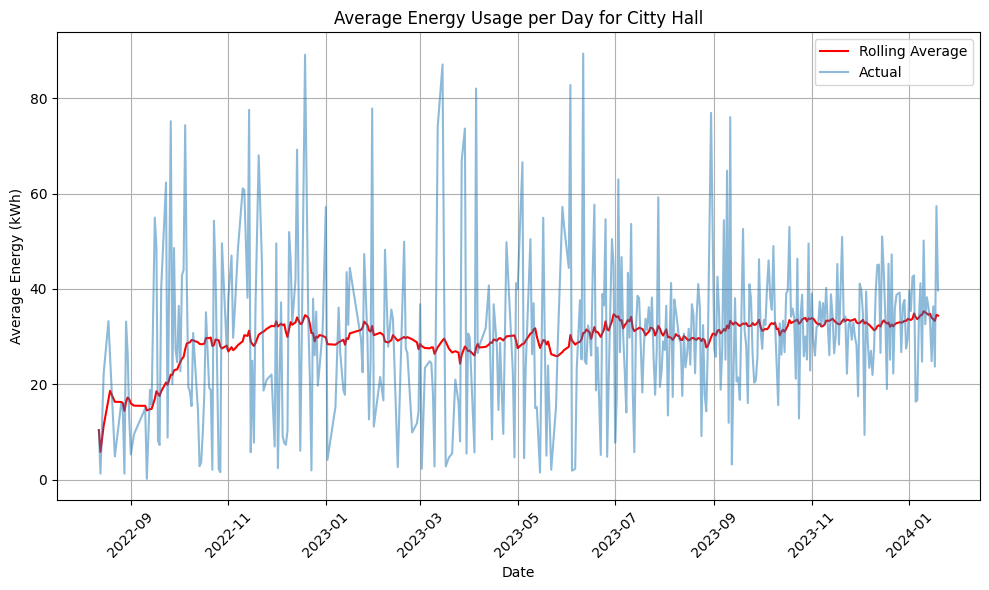

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29236\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


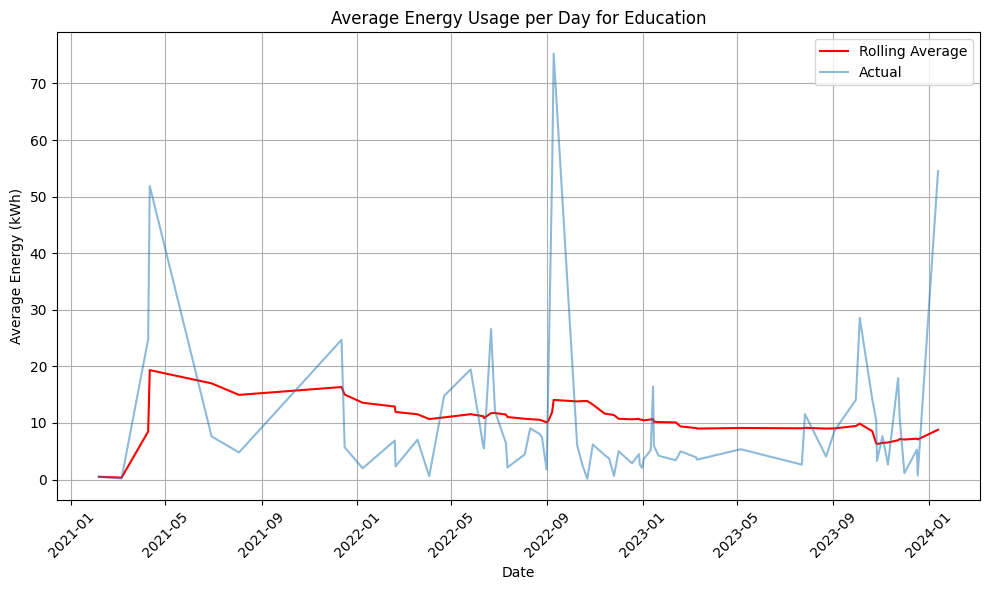

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29236\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


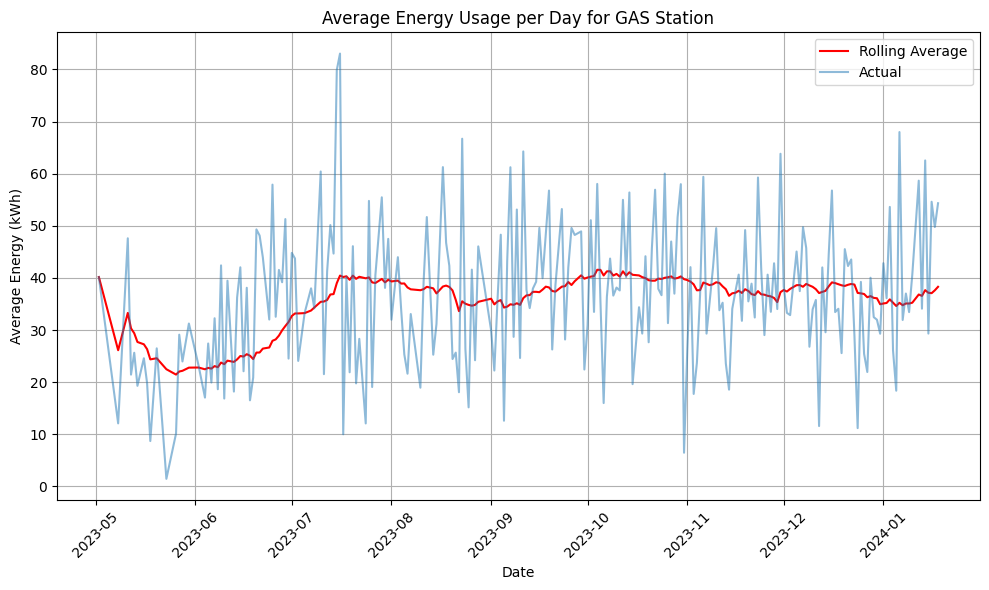

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29236\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


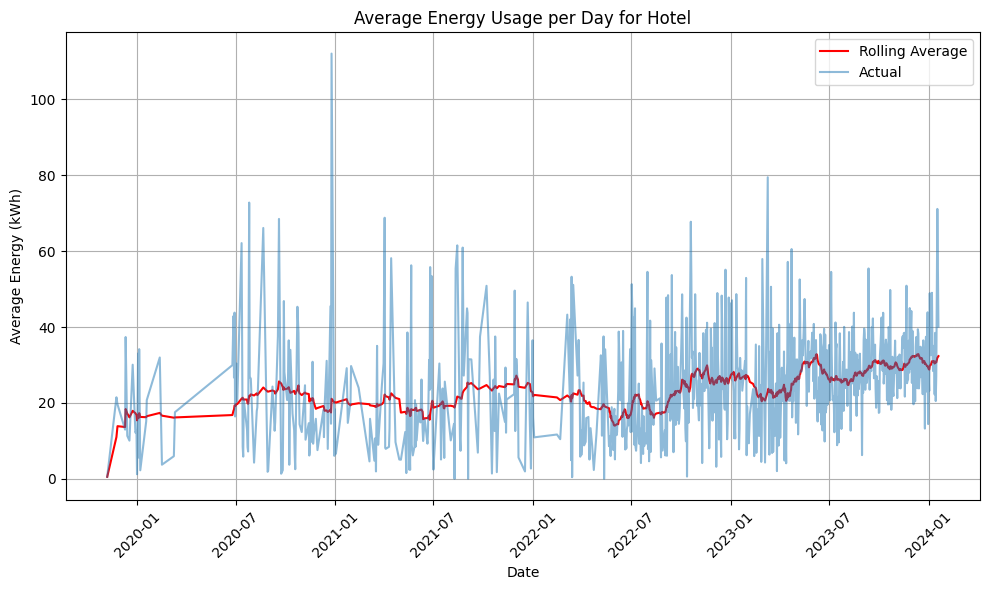

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29236\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


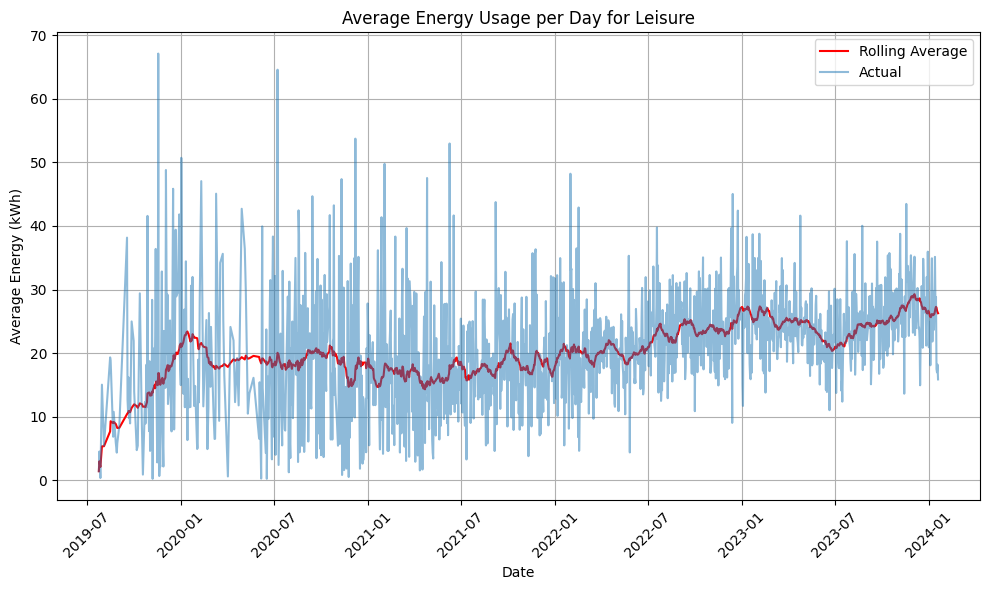

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29236\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


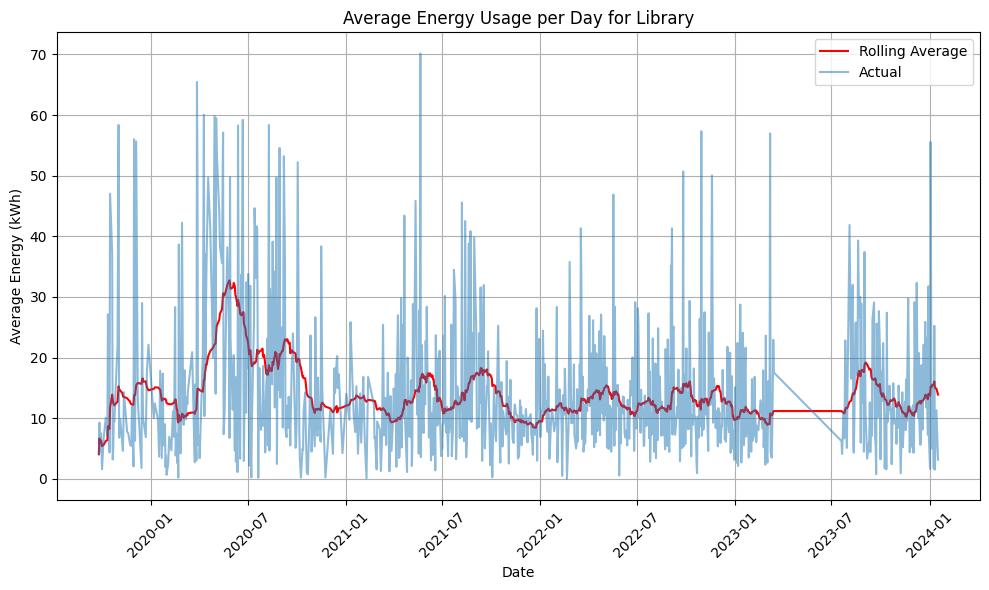

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29236\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


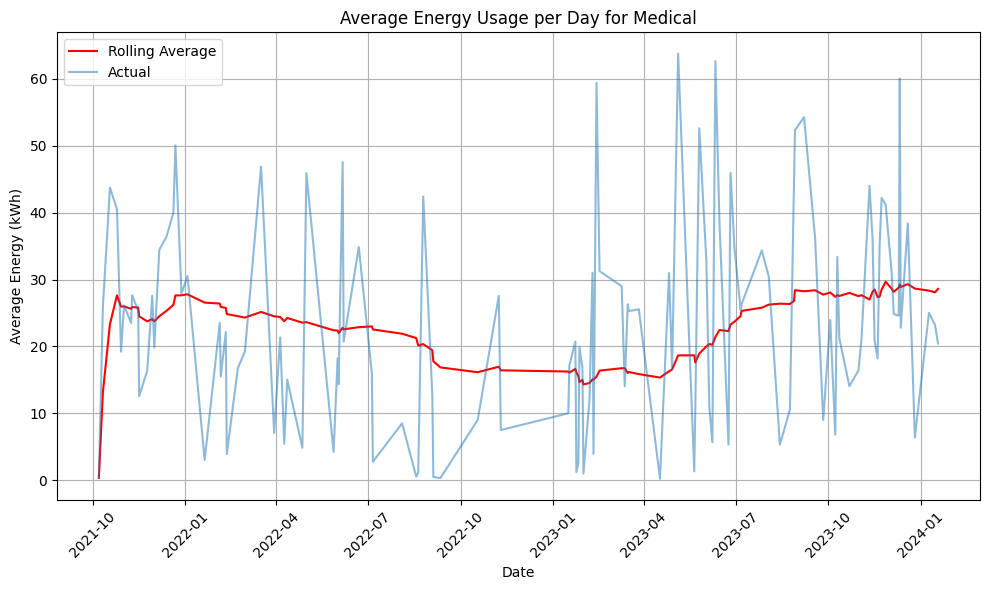

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29236\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


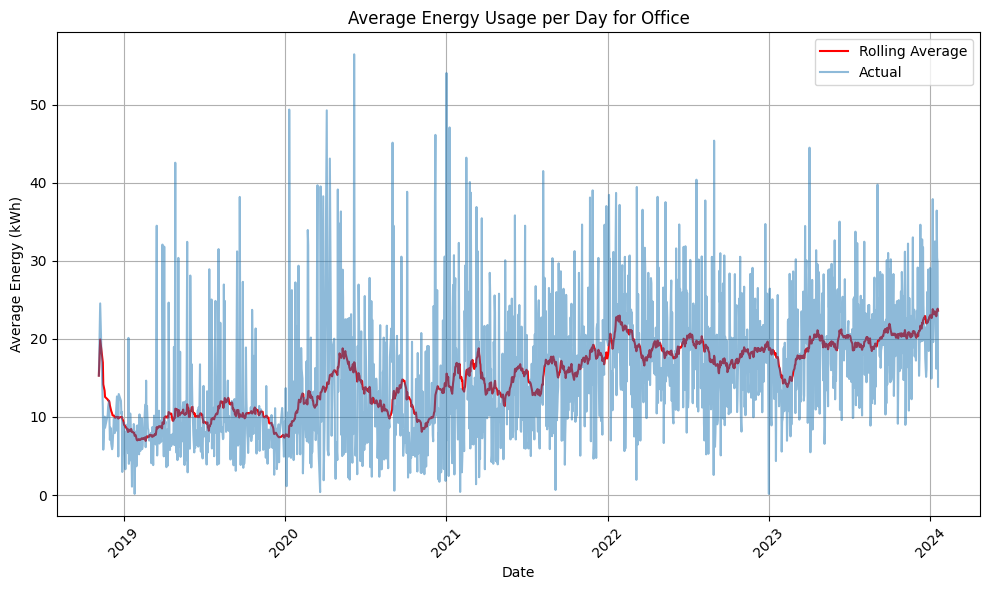

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29236\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


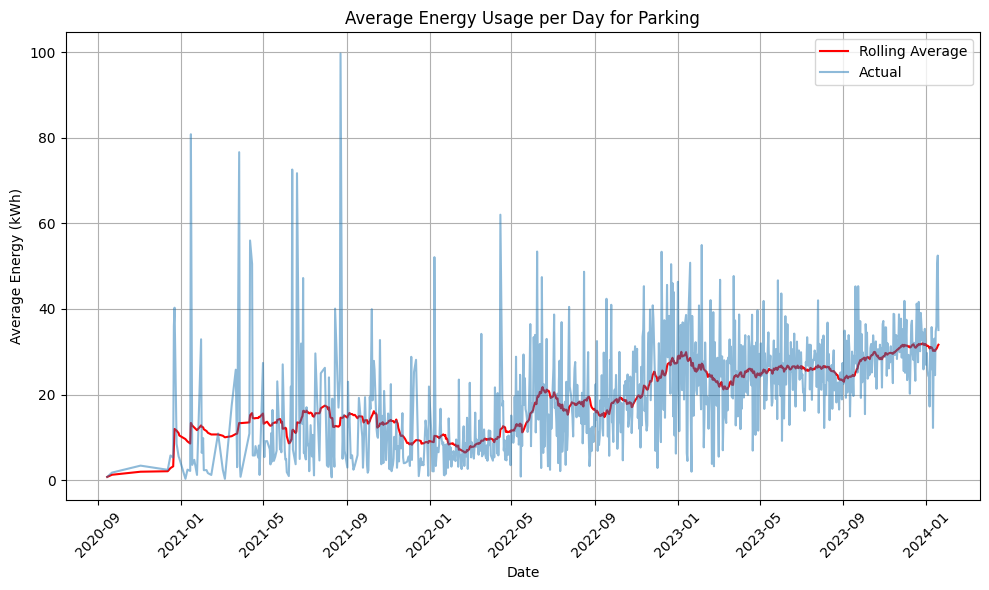

C:\Users\mehdi\AppData\Local\Temp\ipykernel_29236\3846094448.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()


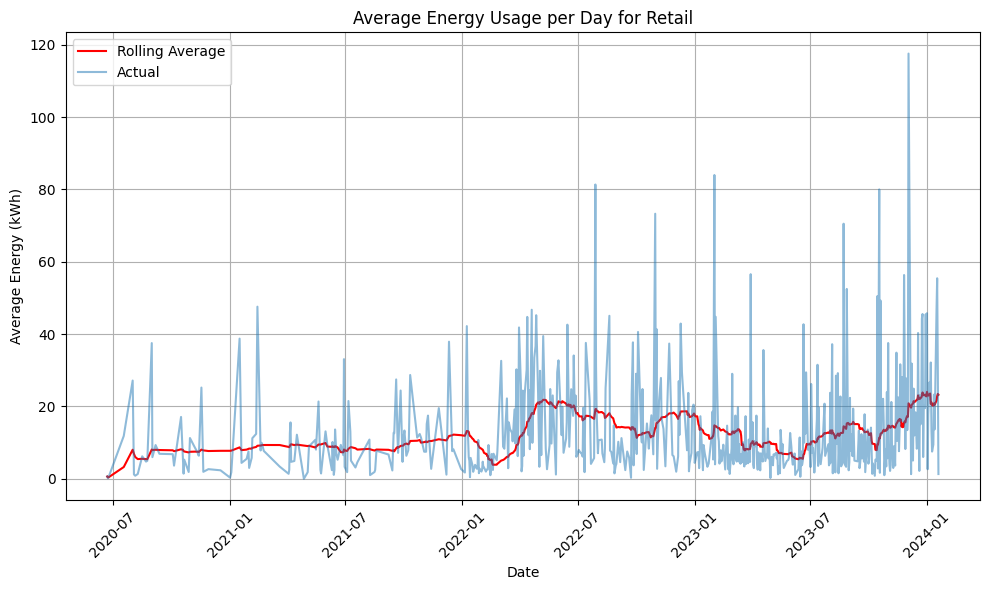

In [55]:

df['Start_Time_EST'] = pd.to_datetime(df['Start_Time_EST'])

df['Date'] = df['Start_Time_EST'].dt.date

# Group by venue and date, and calculate average energy per day for each venue
venue_utilization_data = df.groupby(['Charging Venue', 'Date'])['Energy (kWh)'].mean().reset_index()

# Plot for each venue with a rolling average
venues = venue_utilization_data['Charging Venue'].unique()

for venue in venues:
    plt.figure(figsize=(10, 6))
    venue_data = venue_utilization_data[venue_utilization_data['Charging Venue'] == venue]

    # Calculate a 30-day rolling average for smoother trend
    venue_data['Rolling Average'] = venue_data['Energy (kWh)'].rolling(window=30, min_periods=1).mean()

    plt.plot(venue_data['Date'], venue_data['Rolling Average'], label='Rolling Average', color='red')
    plt.plot(venue_data['Date'], venue_data['Energy (kWh)'], label='Actual', alpha=0.5)

    plt.title(f'Average Energy Usage per Day for {venue}')
    plt.xlabel('Date')
    plt.ylabel('Average Energy (kWh)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [22]:


# Create a map centered around the mean latitude and longitude
center_lat = df_GIS['Latitude'].mean()
center_lon = df_GIS['Longitude'].mean()
map_evse = folium.Map(location=[center_lat, center_lon], zoom_start=5)

# Add markers for each EVSE location with marker size based on the 'Weight' column
for index, row in df_GIS.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Weight'],
        popup=row['Station Name'],
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(map_evse)

# Display the map
#map_evse


KeyError: 'Latitude'

# Perform OLS regression DC only 

In [351]:

independent_vars = ['Energy_Unit_Price','port_kw','Distance (miles)','season','peak_hour','Temp','Fahrenheit_Degree_Days',
                    'Day_of_Week', 'Is_Weekday', 'Is_Weekend', 'ven_HWY','ven_hotel','ven_med_ed',
                    'ven_leisure',  'percentage of poulation', 
                     'ven_office', 'ven_parking', 
                    'cost_free', 'cost_paid', 'Utilization Rate',   
                    'Vehicle_Miles_traveled_Passenger',
                    'Vehicle_Passenger_Number','MED_HH_INCOME',
                     'County_population_2021']

X = utilization_station_data[independent_vars]
Y = utilization_station_data['Util_station (kWh/port/day)']

# Check for infinity and NaN
is_infinite = np.isinf(X).any()
print("Infinite values in independent variables:")
print(is_infinite)
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
print("Number of samples in X:", len(X))
print("Number of samples in Y:", len(Y))


X.reset_index(drop=True, inplace=True)
Y = Y.iloc[X.index]
Y.reset_index(drop=True, inplace=True)

Infinite values in independent variables:
Energy_Unit_Price                   False
port_kw                             False
Distance (miles)                    False
season                              False
peak_hour                           False
Temp                                False
Fahrenheit_Degree_Days              False
Day_of_Week                         False
Is_Weekday                          False
Is_Weekend                          False
ven_HWY                             False
ven_hotel                           False
ven_med_ed                          False
ven_leisure                         False
percentage of poulation             False
ven_office                          False
ven_parking                         False
cost_free                           False
cost_paid                           False
Utilization Rate                    False
Vehicle_Miles_traveled_Passenger    False
Vehicle_Passenger_Number            False
MED_HH_INCOME                     

In [340]:
# Double-check lengths of X and Y
print("Number of samples in X:", len(X))
print("Number of samples in Y:", len(Y))

# Verify index ranges
print("Index range of X:", X.index.min(), "-", X.index.max())
print("Index range of Y:", Y.index.min(), "-", Y.index.max())

# Check if X's indices are within the range of Y's indices
if X.index.max() > Y.index.max() or X.index.min() < Y.index.min():
    print("Indices of X are out of range for Y")

# Check if Y's indices are within the range of X's indices
if Y.index.max() > X.index.max() or Y.index.min() < X.index.min():
    print("Indices of Y are out of range for X")


Number of samples in X: 8167
Number of samples in Y: 8167
Index range of X: 0 - 8166
Index range of Y: 0 - 8166


In [342]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Perform permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Get the feature importances
importances = result.importances_mean

feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances)

Mean Squared Error: 70.35937376307953
R-squared: 0.49002209968682886
                             Feature  Importance
4                          peak_hour    0.349504
0                  Energy_Unit_Price    0.213750
1                            port_kw    0.201193
2                   Distance (miles)    0.132655
6             Fahrenheit_Degree_Days    0.096839
19                  Utilization Rate    0.049985
23            County_population_2021    0.042661
5                               Temp    0.026462
7                        Day_of_Week    0.020193
3                             season    0.012880
22                     MED_HH_INCOME    0.008462
13                       ven_leisure    0.004640
17                         cost_free    0.004053
14           percentage of poulation    0.003946
21          Vehicle_Passenger_Number    0.003161
18                         cost_paid    0.002414
20  Vehicle_Miles_traveled_Passenger    0.001027
11                         ven_hotel    0.000737


In [352]:
# K-Fold cross-validation
model_LR = LinearRegression()
scores = cross_val_score(model_LR, X, Y, cv=5)
print("Cross-validation scores (Linear Regression): ", scores)
print("Average cross-validation score (Linear Regression): ", np.mean(scores))

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)
print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)
print("Testing set:", X_test.shape, Y_test.shape)

# Fit the OLS regression model on the training data
model_ols = sm.OLS(Y_train, X_train).fit()
print(model_ols.summary())

# Calculate the validation score (R-squared)
Y_val_pred = model_ols.predict(X_val)
val_score = r2_score(Y_val, Y_val_pred)
print("Validation R^2 score (OLS): ", val_score)

# Calculate the test score (R-squared)
Y_test_pred = model_ols.predict(X_test)
test_score = r2_score(Y_test, Y_test_pred)
print("Test R^2 score (OLS): ", test_score)

Cross-validation scores (Linear Regression):  [-3.81829535e-01 -2.02075321e+02  3.90390648e-01  2.64890494e-01
 -1.28190120e-02]
Average cross-validation score (Linear Regression):  -40.36293765646213
Training set: (4345, 24) (4345,)
Validation set: (931, 24) (931,)
Testing set: (932, 24) (932,)
                                 OLS Regression Results                                
Dep. Variable:     Util_station (kWh/port/day)   R-squared:                       0.493
Model:                                     OLS   Adj. R-squared:                  0.490
Method:                          Least Squares   F-statistic:                     199.8
Date:                         Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                                 21:55:26   Log-Likelihood:                -17379.
No. Observations:                         4345   AIC:                         3.480e+04
Df Residuals:                             4323   BIC:                         3.494e+04

In [295]:
print(model_ols.summary())

                                 OLS Regression Results                                
Dep. Variable:     Util_station (kWh/port/day)   R-squared:                       0.530
Model:                                     OLS   Adj. R-squared:                  0.526
Method:                          Least Squares   F-statistic:                     145.2
Date:                         Sat, 08 Jun 2024   Prob (F-statistic):               0.00
Time:                                 15:53:30   Log-Likelihood:                -14538.
No. Observations:                         3633   AIC:                         2.913e+04
Df Residuals:                             3604   BIC:                         2.931e+04
Df Model:                                   28                                         
Covariance Type:                     nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

In [296]:
X1 = sm.add_constant(X)
vif = pd.DataFrame()
vif["variables"] = X1.columns
vif["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])]
print(vif)

c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
c:\Users\mehdi\OneDrive - University of Tennessee\Documents\CUIP Projects\EV PTOJECT\sevenstate\py\seven_env\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


                           variables           VIF
0                              const  0.000000e+00
1                  Energy_Unit_Price  1.266208e+00
2                            port_kw  3.061865e+00
3                   Distance (miles)  1.020540e+00
4                             season  1.026231e+00
5                          peak_hour  1.175856e+00
6                               Temp  4.299079e+03
7             Fahrenheit_Degree_Days  5.109575e+03
8                        Day_of_Week  2.662935e+00
9                         Is_Weekday           inf
10                        Is_Weekend           inf
11                    Business_Label           inf
12                         HWY_Label           inf
13                       Hotel_Label           inf
14                        Park_Label           inf
15                       ven_leisure  2.297276e+01
16                            Weight           inf
17                     Grocery_Label           inf
18           percentage of poul

# DT

In [297]:


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initialize the decision tree regressor
model_DT = DecisionTreeRegressor(random_state=42)

# Train the model
model_DT.fit(X_train, Y_train)

# Make predictions
Y_pred = model_DT.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Mean Absolute Error: 11.042579319203599
Mean Squared Error: 254.77566846082206
R-squared: 0.26496706457737884


# RF Hyperparameters

High multicollinearity can be a problem because it can increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable and difficult to interpret.
You might want to consider dropping or transforming some of these variables to address the multicollinearity issue. For example, you could use Principal Component Analysis (PCA) to reduce the dimensionality of your dataset, or you could remove some of the highly correlated variables. You could also consider using regularization techniques like Ridge or Lasso regression which can help in handling multicollinearity.


Correlations with the dependent variable:
Energy_Unit_Price                  -0.067794
port_kw                            -0.042945
Distance (miles)                    0.024018
season                             -0.009400
peak_hour                           0.684927
Temp                               -0.138726
Fahrenheit_Degree_Days             -0.130281
Day_of_Week                         0.060598
Is_Weekday                         -0.061715
Is_Weekend                          0.061715
Business_Label                      0.037026
HWY_Label                          -0.251982
Hotel_Label                         0.229937
Park_Label                         -0.028744
ven_leisure                        -0.083754
Weight                              0.031985
Grocery_Label                       0.052813
percentage of poulation             0.112108
ven_muni                                 NaN
ven_office                          0.250696
ven_parking                              NaN
cost_free   

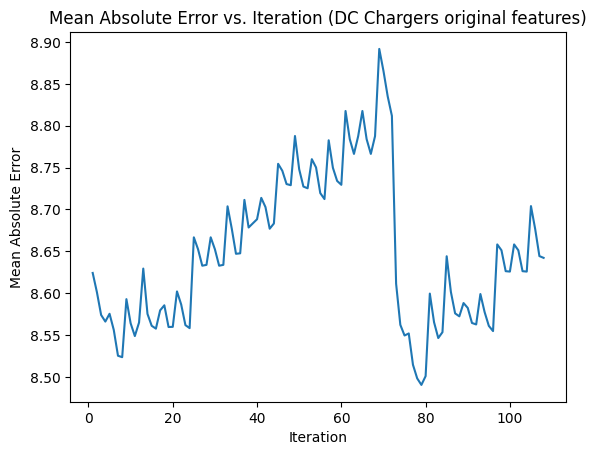


Mean MAE: 8.6485 (+/- 0.0895)
Mean R^2: 0.5969 (+/- 0.0070)
Test MAE: 8.4904
Test R^2: 0.5913


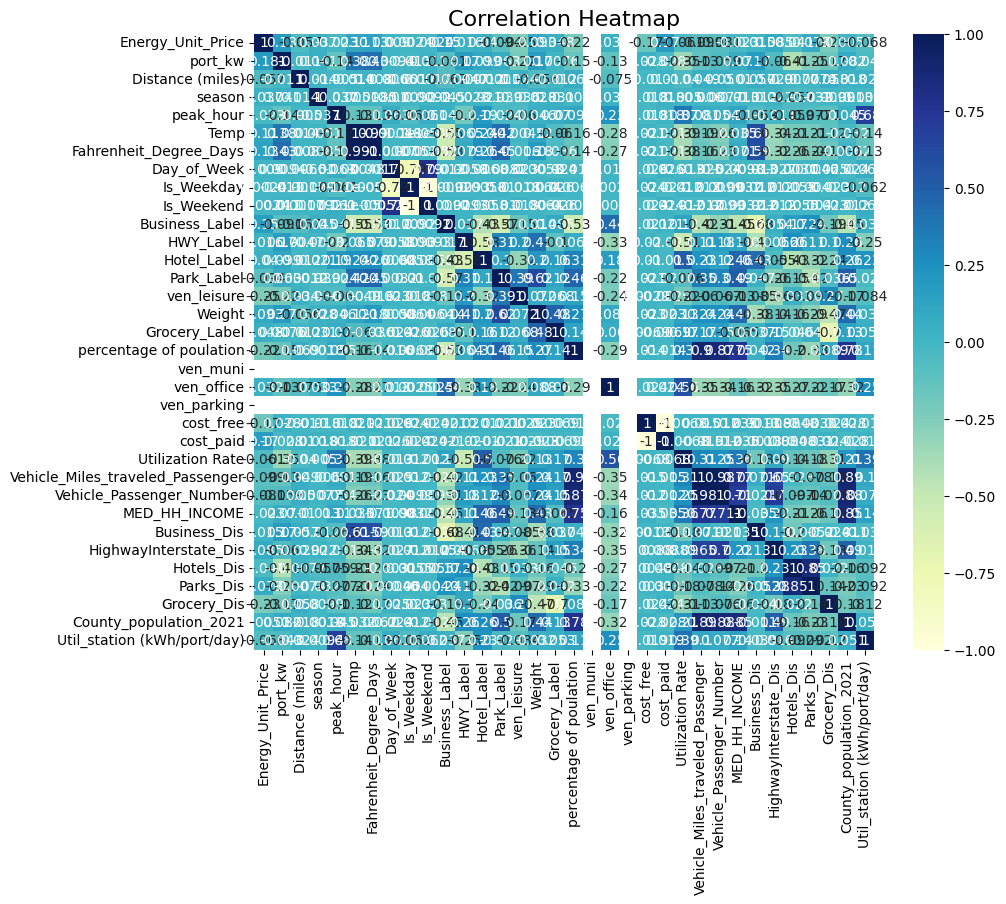

In [298]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Calculate the Pearson correlation coefficients
corr_matrix = X.join(Y).corr()
corr_with_target = corr_matrix[Y.name]

# Print the correlation coefficients with the dependent variable
print("\nCorrelations with the dependent variable:")
print(corr_with_target)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, Y_train)
Y_val_pred = rf_model.predict(X_val)
val_score_rf = r2_score(Y_val, Y_val_pred)
print("Validation R^2 score (Random Forest):", val_score_rf)

Y_test_pred = rf_model.predict(X_test)
test_score_rf = r2_score(Y_test, Y_test_pred)
print("Test R^2 score (Random Forest):", test_score_rf)




param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best Hyperparameters:", best_params)



mae_values = []
train_scores = []
test_scores = []
r2_scores = []  # Initialize r2_scores list

# Perform cross-validation to get MAE, training, and testing scores after each iteration
for i, params in enumerate(grid_search.cv_results_['params']):
    if params['max_features'] != 'auto':  # Check if 'max_features' is set to 'auto'
        rf = RandomForestRegressor(**params, random_state=42)
        rf.fit(X_train, Y_train)

        # Calculate MAE
        Y_pred = rf.predict(X_test)
        mae = mean_absolute_error(Y_test, Y_pred)
        mae_values.append(mae)

        # Calculate R-squared scores for training and testing sets
        train_score = rf.score(X_train, Y_train)
        test_score = rf.score(X_test, Y_test)
        train_scores.append(train_score)
        test_scores.append(test_score)

        # Calculate R-squared score for validation set
        r2_score_val = r2_score(Y_val, rf.predict(X_val))
        r2_scores.append(r2_score_val)

        print(f"Iteration {i+1}: MAE = {mae}, Train Score = {train_score}, Test Score = {test_score}, Val Score = {r2_score_val}")
    else:
        print(f"Iteration {i+1}: 'max_features' is set to 'auto', skipping...")


# Plot MAE values
plt.plot(range(1, len(mae_values) + 1), mae_values, marker='', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error vs. Iteration (DC Chargers original features)')
plt.show()

from sklearn.metrics import r2_score
# Calculate the mean and standard deviation of MAE and R^2
mae_mean = np.mean(mae_values)
mae_std = np.std(mae_values)
r2_mean = np.mean(r2_scores)
r2_std = np.std(r2_scores)
print(f"\nMean MAE: {mae_mean:.4f} (+/- {mae_std:.4f})")
print(f"Mean R^2: {r2_mean:.4f} (+/- {r2_std:.4f})")

# Make predictions on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}") 
print(f"Test R^2: {test_r2:.4f}")

# Create a heatmap visualization for correlation 
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

Correlations with the dependent variable:
Energy_Unit_Price   -0.173883
port_kw             -0.016780
Distance (miles)     0.043269
season               0.046078
peak_hour            0.608880
Temp                -0.076413
Name: Util_station (kWh/port/day), dtype: float64
Pearson correlation coefficient: -0.17388338390986302


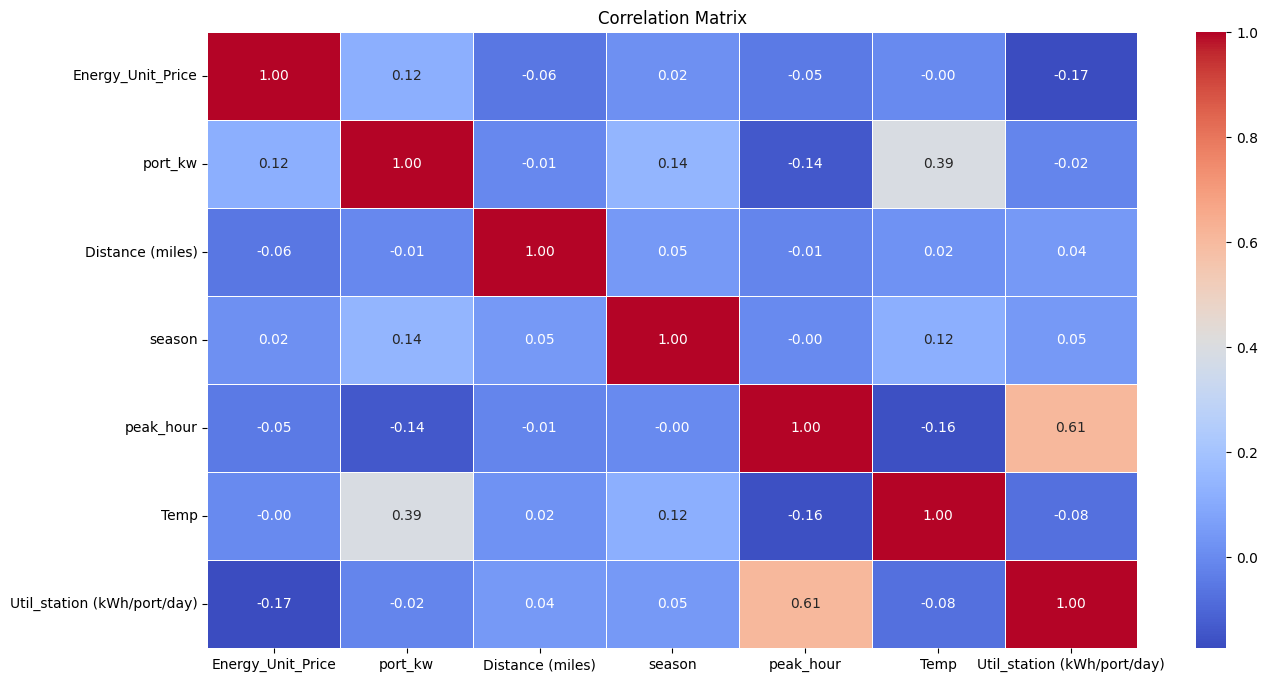

In [218]:
# Combine independent variables and dependent variable into one DataFrame
df_combined = pd.concat([X, Y], axis=1)

# Calculate correlations
correlations = df_combined.corr()

# Extract correlation values with the dependent variable
corr_with_dependent = correlations.iloc[:-1, -1]

# Print correlations with the dependent variable
print("Correlations with the dependent variable:")
print(corr_with_dependent)

# Calculate Pearson correlation coefficient
pearson_coefficient = df_combined.corr().iloc[:-1, -1].values[0]

print("Pearson correlation coefficient:", pearson_coefficient)

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations
correlations = df_combined.corr()

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.8}
Test MAE: 10.2441
Test R^2: 0.3730


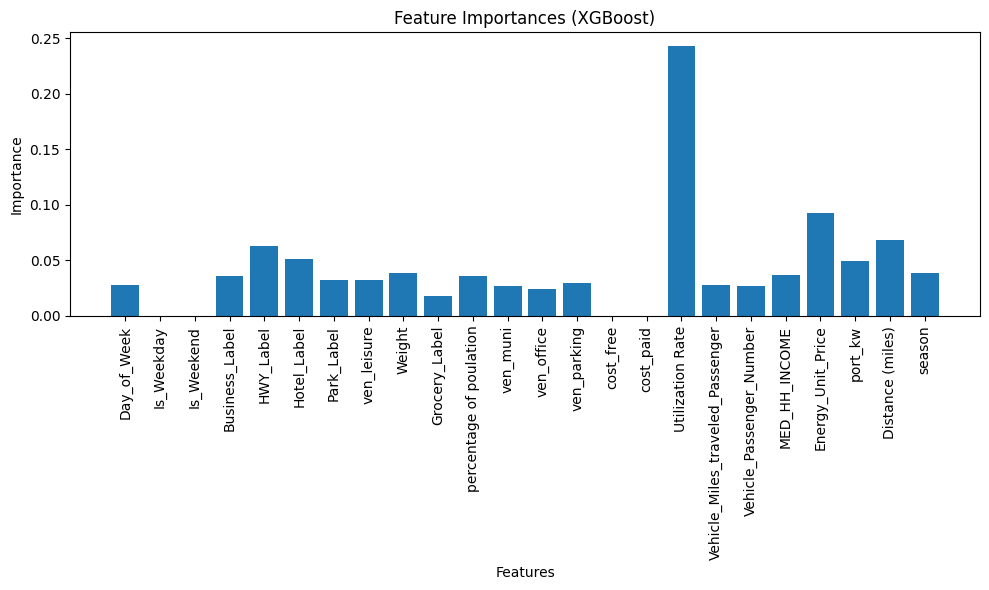

In [164]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import xgboost as xgb


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameter
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search with cross-validation
grid_search_XG = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_XG.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search_XG.best_params_
best_estimator = grid_search_XG.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate the model on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Plot feature importances
importances = best_estimator.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

Test MAE: 13.6362
Test R^2: -0.0189


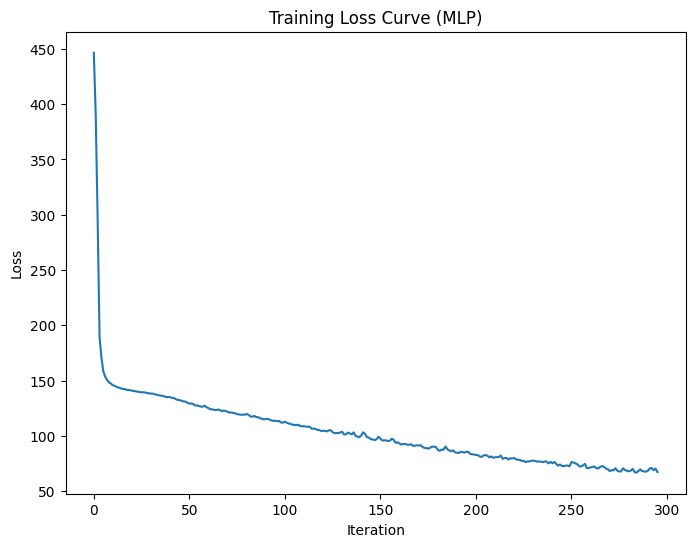

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an MLP regressor
mlp_model = MLPRegressor(hidden_layer_sizes=(200,100, 50), activation='relu', solver='adam',
                         alpha=0.0001, max_iter=1000, random_state=42)

# Train the model
mlp_model.fit(X_train_scaled, Y_train)

# Make predictions on the test set
Y_pred = mlp_model.predict(X_test_scaled)

# Evaluate the model
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Plot the training loss curve
plt.figure(figsize=(8, 6))
plt.plot(mlp_model.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Curve (MLP)')
plt.show()

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 300, 'subsample': 0.8}
Test MAE: 10.4626
Test R^2: 0.3679


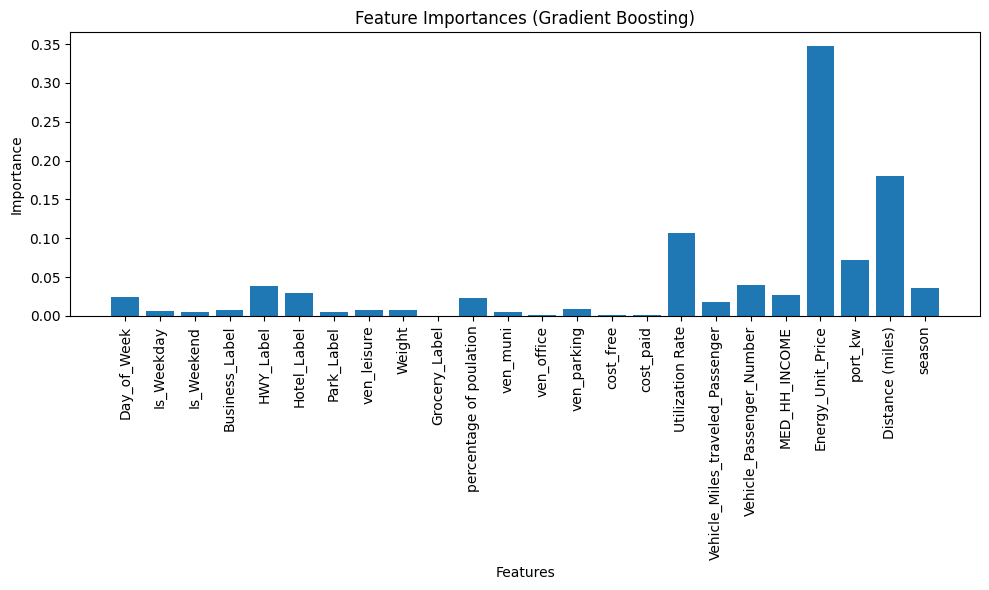

In [166]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

gb_model = GradientBoostingRegressor(random_state=42)

# Define the hyperparameter 
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'max_features': ['sqrt', 'log2']
}

# Perform grid search with cross-validation
grid_search_GBR = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_GBR.fit(X_train, Y_train)

# Get the best hyperparameters and the best estimator
best_params = grid_search_GBR.best_params_
best_estimator = grid_search_GBR.best_estimator_
print("Best Hyperparameters:", best_params)

# Evaluate the model on the test set
Y_pred = best_estimator.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)
test_r2 = r2_score(Y_test, Y_pred)
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R^2: {test_r2:.4f}")

# Plot feature importances
importances = best_estimator.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (Gradient Boosting)')
plt.tight_layout()
plt.show()